# Содержание

* [1 Подготовка данных](#1-Подготовка-данных)
    - [1.1 Загрузка данных](#1.1-Загрузка-данных)
    - [1.2 Обработка целевого признака](#1.2-Обработка-целевого-признака)
    - [1.3 Разделение на выборки](#1.3-Разделение-на-выборки)
    - [1.4 Кодирование данных](#1.4-Кодирование-данных)
* [2 Обучение модели](#2-Обучение-модели)
    - [2.1 Baseline](#2.1-Baseline)
    - [2.2 FCNN](#2.2-FCNN)
    - [2.3 Выбор модели](#2.3-Выбор-модели)
* [3 Тестирование модели](#3-Тестирование-модели)
* [4 Экспорт модели](#4-Экспорт-модели)
* [5 Общий вывод](#5-Общий-вывод)

# Этап 2. Подбор модели

**Проект:** Разработка системы распознавания кухни по продукту с рекомендацией района, его предоставляющего.

**Задача:** Подбор модели классификации.

**Источник данных:** `/data/data_sg/data_train` и `/data/data_sg/data_test`.

**Характер данных:** сведения о заказах в Сингапуре ([Delivery Hero Recommendation Dataset](https://drive.google.com/file/d/12N6iHczXIVX4E_KM15jxeJ_7WQ2urHFq/view)).

**Цель:** Подбор модели в рамках создания рекомендательной системы.

>* *Целевой признак* - кухня, на которой специализируется продавец (`primary_cuisine`).

по которому можно указать точку на карте

(загрузил фотку / написал "курица" - выдать ближайшие рестораны) как ранжирование, рекомендательная система

Определение | Описание
-|-
**Образ результата** | Рекомендательная система на основе прогнозирования кухни
**Тип задачи** | NLP + Рекомендательная система
**Входные данные** | Строка с названием желаемого блюда
**Выходные данные** | Вид кухни (**`primary_cuisine`**)
**Итоговый вывод** | Рекомендация ресторанов, предоставляющих блюдо и<br>специализирующихся на соответствующей блюду кухне

>* С учётом планируемого результата разработки системы рекомендации путь пользователя будет выглядеть следующим образом:
>    1. Пользователь вводит название блюда.
>    2. Предсказательная модель:
>        * Определяет кухню, к которой относится введённое название. В случае несовпадения выводится фраза `Cannot recognize the cuisine`.
>        * С учётом определённой кухни, текущих часа и времени суток, а также расположения пользователя и его отдалённость от продавца рекомендует пользователю ТОП-5 точек, предлагающих это блюдо.
>* Таким образом, в качестве признаков будут взяты столбцы: `distance_to_vendor`, `geohash`, `geohash_vendor`, `time_of_day`, `hour`, `name`.
>* В качестве завершающего этапа подготовки данных необходимо произвести векторизацию текстов.

две задачи: многоклассовая классификация и рекомендательная система

---

## 1 Подготовка данных

### 1.1 Загрузка данных

Установка библиотек:

In [1]:
%%capture no-display
!pip install scikit-multilearn pickle

Импорт библиотек:

In [2]:
import pandas as pd
import numpy as np

import os
import pickle

from typing import Tuple
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Model, Sequential, layers, optimizers
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score

Игнорирование предупреждений:

In [3]:
import warnings

warnings.filterwarnings('ignore')

Фисксирование случайных величин:

In [4]:
SEED = 42

tf.random.set_seed(SEED)

Задание пути до папки с данными:

In [5]:
PATH = 'data/data_sg/preprocessed_data/'

Выведение на экран содержимого папки с данными:

In [6]:
os.listdir(PATH)

['data_test.csv',
 'data_test_cuisine.csv',
 'data_train.csv',
 'data_train_cuisine.csv']

Загрузка данных:

In [7]:
join_path = lambda x: os.path.join(PATH, x)

data_train = pd.read_csv(join_path('data_train_cuisine.csv'), index_col=0)
data_test = pd.read_csv(join_path('data_test_cuisine.csv'), index_col=0)

Выведение на экран первых строк набора данных:

In [8]:
data_train.head(3)

,name,multilabels
0,chicken cutlet with rice,"western, singaporean, chicken, chinese, fried ..."
1,chicken chop,"western, chicken, indian, fried chicken, chine..."
2,chicken wings with rice,"western, chicken, asian"


---

### 1.2 Обработка целевого признака

Выведение на экран общего количества уникальных классов:

In [9]:
print('Total labels:', len(set(', '.join(data_train['multilabels']).split(', '))))

Total labels: 78


Преобразование строк с классами в списки:

In [10]:
split_labels = lambda x: x['multilabels'].str.split(', ')

data_train['multilabels'] = split_labels(data_train)
data_test['multilabels'] = split_labels(data_test)

Выведение на экран первых строк набора данных для проверки применённых изменений:

In [11]:
data_train.head(3)

,name,multilabels
0,chicken cutlet with rice,"[western, singaporean, chicken, chinese, fried..."
1,chicken chop,"[western, chicken, indian, fried chicken, chin..."
2,chicken wings with rice,"[western, chicken, asian]"


Объявление объекта кодирования:

In [12]:
multilabel = MultiLabelBinarizer()

Обучение объекта кодирования:

In [13]:
multilabel.fit(data_train['multilabels'])

MultiLabelBinarizer()

Кодирование классов целевого признака:

In [14]:
join_multilabel = lambda x: x.join(
    pd.DataFrame(
        multilabel.transform(x['multilabels']), 
        columns=multilabel.classes_
    )
)

data_train = join_multilabel(data_train)
data_test = join_multilabel(data_test)

Выведение на экран первых строк набора данных для проверки применённых изменений:

In [15]:
data_train.head(1)

,name,multilabels,acai bowl,american,asian,ayam penyet,bak kut teh,bakery,ban mian,beverages,...,spanish,sushi,tea,thai,turkish,vegetarian,vietnamese,western,wraps,yong tau foo
0,chicken cutlet with rice,"[western, singaporean, chicken, chinese, fried...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


---

### 1.3 Разделение на выборки

Перемешивание обучающего набора данных:

In [16]:
data_train_shuffle = data_train.sample(frac=1, random_state=SEED)

Разделение наборов данных на обучающие признаки и целевые признаки:

In [17]:
get_y = lambda x: np.array(x[x.columns[2:]]) 

X_train = data_train['name'].to_numpy()
y_train = get_y(data_train)

X_test = data_test['name'].to_numpy()
y_test = get_y(data_test)

Разделение обучающей выборки на обучающую и валидационную:

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=SEED)

Выведение на экран размеров выборок:

In [19]:
print('X_train shape:', X_train.shape)
print('X_val shape:', X_val.shape)
print('X_test shape:', X_test.shape)

X_train shape: (60965,)
X_val shape: (6774,)
X_test shape: (43625,)


---

### 1.4 Кодирование данных

Задание функции, трансформирующей многоклассовую последовательность в слова:

In [20]:
def transform_label(label, vocab):
    '''
    '''
    
    return vocab.inverse_transform(np.array([label]))

---

Выведение на экран образца объекта с кодированием и раскодированием его целевого признака:

In [21]:
print(
    'meal:', X_train[0], 
    '\n\ncuisine label:\n', y_train[0], 
    '\n\ncuisine:', transform_label(y_train[0], multilabel)
)

meal: panlasang pinoy 

cuisine label:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0] 

cuisine: [('filipino',)]


---

**TfidfVectorizer**

Выведение на экран числовых характеристик обучающей выборки:

In [22]:
round(pd.Series(X_train).str.len().describe(), 1)

count    60965.0
mean        21.6
std          8.4
min          3.0
25%         15.0
50%         21.0
75%         27.0
max         60.0
dtype: float64

Задание констант:

In [23]:
n_labels = len(multilabel.classes_)

max_vocab_len = len(set(' '.join(list(X_train)).split()))
max_out_len = round(pd.Series(X_train).str.len().sum() / X_train.shape[0])

print('Total labels:', n_labels)
print('\nMaximum vocabulatory length:', max_vocab_len)
print('Maximum output length:', max_out_len)

Total labels: 78

Maximum vocabulatory length: 10385
Maximum output length: 22


Задание объекта векторизации:

In [24]:
vectorizer_tfidf = TfidfVectorizer(
    max_features=max_vocab_len,
    analyzer='word',
    ngram_range=(1, 2),
    stop_words='english'
)

---

**layers.TextVectorization**

Задание слоя векторизации:

In [25]:
vectorizer_text_tfidf = layers.TextVectorization(
    max_tokens=max_vocab_len, 
    ngrams=2, 
    output_mode='tf_idf'
)

Обучение объекта векторизации:

In [26]:
with tf.device('/CPU:0'):
    vectorizer_text_tfidf.adapt(X_train)

Трансформация выборок:

In [27]:
with tf.device('/CPU:0'):
    X_train_vect = vectorizer_text_tfidf(X_train)
    X_val_vect = vectorizer_text_tfidf(X_val)
    X_test_vect = vectorizer_text_tfidf(X_test)

---

## 2 Обучение модели

Задание функции, сохраняющей переданные результаты вычисления метрик:

In [28]:
def save_results(name, accuracy, save_to: pd.DataFrame) -> None:
    '''
    '''
    if name is None:
        print('\nScore:', round(accuracy, 2))
        
    else:
        save_to.loc[name, 'accuracy'] = round(accuracy, 2)

        display(pd.DataFrame(save_to.loc[name]).T)

Задание функции, выводящей таблицу для сравнения предсказаний с ответами:

In [29]:
def compare_pred_true(model, 
                      X: pd.Series, 
                      y: pd.Series, 
                      preds, 
                      limit: int = 5) -> None:
    
    '''
    '''
    
    df = []
    
    for i in range(limit):
        label_pred = transform_label(preds[i], multilabel)
        label_true = transform_label(y[i], multilabel)
        
        df.append([X[i], label_pred, label_true])
        
    display(pd.DataFrame(df, columns=['name', 'prediction', 'true']))

Задание функции, строящей графики метрики и функции потерь:

In [30]:
def plot_history(history, score_name):
    '''
    '''
    
    accuracy_train = history.history[score_name]
    accuracy_val = history.history[f'val_{score_name}']
    
    loss_train = history.history['loss']
    loss_val = history.history['val_loss']
    
    x = range(len(accuracy_train))

    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(x, accuracy_train, 'b', label=f'train {score_name}')
    plt.plot(x, accuracy_val, 'r', label=f'valid {score_name}')
    plt.title(f'Train and valid {score_name}\n')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(x, loss_train, 'b', label='train loss')
    plt.plot(x, loss_val, 'r', label='valid loss')
    plt.title('Train and valid loss\n')
    plt.legend()
    
    plt.show()

Задание функции, вычисляющей метрики:

In [31]:
def get_score(model, X, y, preds) -> float:
    '''
    '''
    
    try:
        accuracy = accuracy_score(y, preds)
    except:
        accuracy = model.evaluate(X, y)[1]
    
    return accuracy

Задание функции обучения модели:

In [32]:
def train_model(model, train_data, valid_data, name: str, save_to, threshold: float = 0.5, valid_data_init = None):
    '''
    '''
    if train_data is not None:
        X_t, y_t = train_data
        model.fit(X_t, y_t)
        
    X_v, y_v = valid_data
    
    preds = model.predict(X_v)
    
    score = get_score(model, X_v, y_v, preds)
    
    if train_data is None:
        preds = transform_probs_to_labels(preds, threshold)
    
    save_results(name, score, save_to)
    
    if valid_data_init is not None:
        X_v = valid_data_init
    
    if score > 0.5:
        compare_pred_true(model, X_v, y_v, preds)
    
    return model

---

Объявление переменной, которая будет хранить результаты вычисления метрик моделей:

In [33]:
results = pd.DataFrame(columns=['accuracy'])

---

### 2.1 Baseline

Объявление пайплайна обучения модели:

In [34]:
pipeline = Pipeline([
    ('tfidf', vectorizer_tfidf),
    ('model', OneVsRestClassifier(LogisticRegression()))
])

Обучение модели:

In [35]:
model_0 = train_model(
    pipeline, 
    train_data=(X_train, y_train), 
    valid_data=(X_val, y_val), 
    name='log_reg', 
    save_to=results
)

,accuracy
log_reg,0.2


---

### 2.2 FCNN

Задание функции, трансформирующей вероятности классов в классы:

In [36]:
def transform_probs_to_labels(probs, threshold: float = 0.5):
    '''
    '''
    
    return (probs > threshold).astype(int)

---

Объявление модели:

In [37]:
model_1 = Sequential([
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.Dense(n_labels, activation='sigmoid'),
])

Настройка модели:

In [38]:
model_1.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.Adam(learning_rate=1e-3), 
    metrics=['accuracy']
)

Обучение модели:

In [39]:
history_1 = model_1.fit(
    X_train_vect, 
    y_train, 
    validation_data=(X_val_vect, y_val), 
    epochs=5,
    batch_size=64
)

Epoch 1/5
953/953 [==============================] - 12s 12ms/step - loss: 0.0606 - accuracy: 0.4140 - val_loss: 0.0487 - val_accuracy: 0.4711
Epoch 2/5
953/953 [==============================] - 10s 11ms/step - loss: 0.0366 - accuracy: 0.5736 - val_loss: 0.0486 - val_accuracy: 0.4683
Epoch 3/5
953/953 [==============================] - 10s 11ms/step - loss: 0.0292 - accuracy: 0.6467 - val_loss: 0.0520 - val_accuracy: 0.4550
Epoch 4/5
953/953 [==============================] - 11s 11ms/step - loss: 0.0243 - accuracy: 0.7026 - val_loss: 0.0558 - val_accuracy: 0.4644
Epoch 5/5
953/953 [==============================] - 10s 11ms/step - loss: 0.0201 - accuracy: 0.7503 - val_loss: 0.0603 - val_accuracy: 0.4572


Построение графиков метрики и функции потерь:

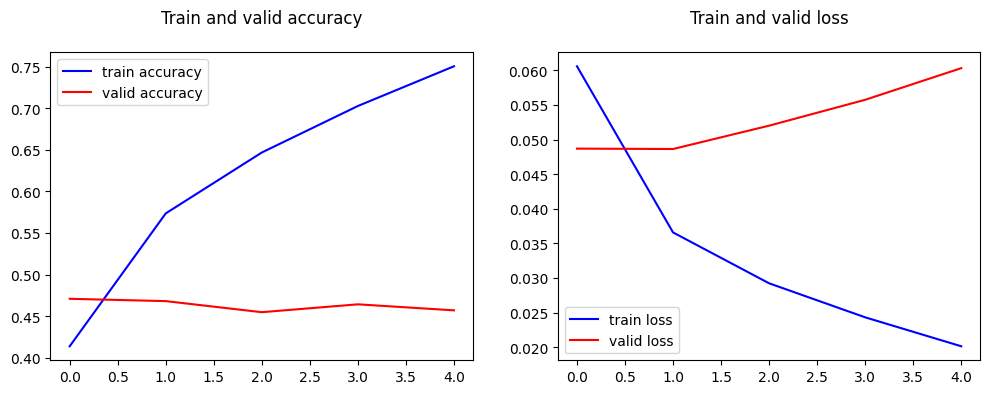

In [40]:
plot_history(history_1, 'accuracy')

Получение предсказаний:

In [41]:
train_model(
    model_1, 
    train_data=None, 
    valid_data=(X_val_vect, y_val), 
    name='fcnn', 
    save_to=results,
    valid_data_init=X_val
)

212/212 [==============================] - 1s 4ms/step - loss: 0.0603 - accuracy: 0.4572


,accuracy
fcnn,0.46


---

### 2.3 Выбор модели

Выведение на экран таблицы с результатами метрик:

In [42]:
results

,accuracy
log_reg,0.2
fcnn,0.46


---

## 3 Тестирование модели

Задание лучшей модели:

In [43]:
best_model = model_1

Получение предсказаний:

In [44]:
train_model(
    best_model, 
    train_data=None, 
    valid_data=(X_test_vect, y_test), 
    name=None, 
    save_to=results,
    valid_data_init=X_test
)

1364/1364 [==============================] - 6s 5ms/step - loss: 0.0256 - accuracy: 0.7303

Score: 0.73


,name,prediction,true
0,japanese garlic karaage don,"[(ramen,)]","[(ramen,)]"
1,chicken cutlet don,"[(japanese,)]","[(ramen,)]"
2,beef sukiyaki don,"[(japanese,)]","[(ramen,)]"
3,japanese beef yakiniku don,"[(ramen,)]","[(ramen,)]"
4,teriyaki salmon don,"[(japanese, ramen, seafood)]","[(japanese, ramen, seafood)]"


---

## 4 Экспорт модели

Задание путей до файлов:

In [45]:
PATH_WEB = 'webapp/model/'

join_path = lambda x: os.path.join(PATH_WEB, x)

path_multilabel = join_path('multilabel.pkl')
path_model = join_path('model.h5')
path_vectorizer = join_path('vectorizer.pkl')

---

**Multilabel**

Сохранение объекта кодирования:

In [46]:
pickle.dump(multilabel, open(path_multilabel, 'wb'))

Загрузка объекта кодирования:

In [47]:
multilabel_loaded = pickle.load(open(path_multilabel, 'rb'))

---

**Model**

Сохранение модели:

In [48]:
best_model.save(path_model)

Загрузка модели:

In [49]:
model_loaded = load_model(path_model)

---

**TextVectorization**

Сохранение векторизатора:

In [50]:
pickle.dump(
    {
        'config': vectorizer_text_tfidf.get_config(),
        'weights': vectorizer_text_tfidf.get_weights()
    }, 
    open(path_vectorizer, 'wb')
)

Загрузка векторизатора:

In [51]:
vectorizer_file = pickle.load(open(path_vectorizer, 'rb'))

Настройка конфигурации векторизатора:

In [ ]:
vectorizer_loaded = layers.TextVectorization.from_config(vectorizer_file['config'])

---

Задание тестового значения:

In [52]:
test_data = 'teriyaki salmon don'

Настройка векторизатора:

In [53]:
vectorizer_loaded.adapt([test_data])

Настройка весов векторизатора:

In [54]:
vectorizer_loaded.set_weights(vectorizer_file['weights'])

Выведение на экран закодированного тестового значения:

In [55]:
vectorizer_loaded([test_data])

<tf.Tensor: shape=(1, 10385), dtype=float32, numpy=array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

Получение предсказаний:

In [81]:
transform_label(
    *transform_probs_to_labels(
        model_loaded.predict(
            vectorizer_loaded([test_data])
        )
    ),
    multilabel_loaded
)

1/1 [==============================] - 0s 21ms/step


[('japanese', 'ramen', 'seafood')]

---

## 5 Общий вывод

<div style="text-align: center; font-size: 20px; padding: 15px 0;">
    <a href="#Содержание" data-toc-modified-id="Содержание" style="text-decoration: none; color: #296eaa; border: 2px dashed #296eaa; opacity: 0.8; border-radius: 3px; padding: 10px 80px;">
        В начало файла ↑
    </a>
</div>